In [3]:
import sys
sys.path.append('../..')
import ugent
import numpy as np
from math import pi

In [4]:
def T(alpha, t):
    cy = 1/np.sin(alpha)
    # beta = asin(t * sin(pi/2 - alpha))
    beta = t * alpha
    r = 1/np.tan(alpha)
    return (r*np.sin(beta), cy - r*np.cos(beta))

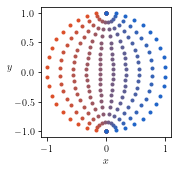

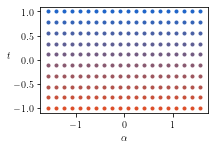

In [5]:
import matplotlib.pyplot as plt
import string
import numpy as np
import matplotlib as mpl

mpl.rc('font', family='serif', size=10, serif="Computer Modern Roman")
mpl.rc('text', usetex=True)

alphas = np.linspace(float(-pi/2), float(pi/2), 20)
ts = np.linspace(-1, 1, 10)

base = 0.6
f1, ax1 = plt.subplots(figsize=(5*base,4*base))
f2, ax2 = plt.subplots(figsize=(5*base,4*base))

ax1.set_aspect(1)
ax2.set_aspect(1)

for i, t in enumerate(ts):
    c = ugent.mix(ugent.rood, ugent.blauw, i/(len(ts)-1))
    ax1.plot(*zip(*(T(alpha, t) for alpha in alphas)), '.', color=c)
    ax2.plot(*zip(*((alpha, t) for alpha in alphas)), '.', color=c)

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$', rotation=0)

ax2.set_xlabel('$\\alpha$')
ax2.set_ylabel('$t$', rotation=0)

f1.savefig("disc_transformed.pdf", bbox_inches="tight")
f2.savefig("disc_original.pdf", bbox_inches="tight")

In [6]:
var('alpha, t')
sT = vector(SR, T(alpha,t))
sTa = diff(sT, alpha)
sTt = diff(sT, t)
sTaa = diff(sTa, alpha)
sTat = diff(sTa, t)
sTtt = diff(sTt, t)

ua, va = sTa
ut, vt = sTt
uaa, vaa = sTaa
uat, vat = sTat
utt, vtt = sTtt

cs = (matrix([
        [ua, va, 0, 0, 0],
        [ut, vt, 0, 0, 0],
        [uaa, vaa, ua*ua, 2*ua*va, va*va],
        [uat, vat, ua*ut, (ut*va+ua*vt), va*vt],
        [utt, vtt, ut*ut, 2*ut*vt, vt*vt]
]).solve_left(vector([0,0,1,0,1]))).simplify_full()

cs = [fast_callable(c, vars=(alpha, t), domain=float) for c in cs]

In [32]:
import numpy as np
import scipy.linalg as scl
import scipy.sparse as scs
import scipy.sparse.linalg as scsl

na = 61
nt = 61

assert na%2 == 1

alphas = np.linspace(float(-pi/2), float(pi/2), na+1)
ha = float(alphas[1] - alphas[0])

indices = [(int(i), int(j)) for j in range(1, nt) for i in range(1, na)]

def tridiag(abc, n):
    a, b, c = abc
    return matrix.toeplitz([b, a] + [0]*(n-2), [c] + [0]*(n-2), ring=RDF).numpy(dtype="float")

def D1(n):
    return tridiag((-1, 0, 1), n)

def D2(n):
    return tridiag((1, -2, 1), n)

def I(n):
    return np.eye(n, dtype="float")

def k(A, B):
    return np.kron(A, B)

Ma = k(I(nt-1), D1(na-1))/float(2*ha)
Mt = k(D1(nt-1), I(na-1))/float(2)
Maa = k(I(nt-1), D2(na-1))/float(ha*ha)
Mat = k(I(nt-1), D1(na-1)) @ k(D1(nt-1), I(na-1))/float(4*ha)
Mtt = k(D2(nt-1), I(na-1))

def matrix_problem(epsilon):
    ts = np.linspace(-1, float(2*epsilon-1), nt+1)
    ht = float(ts[1] - ts[0])

    def C(k):
        v = np.ndarray((len(indices),), dtype="float")
        for l, (i, j) in enumerate(indices):
            v[l] = cs[k](alphas[i], ts[j])
        return v
    
    M = scs.dia_matrix(np.multiply(C(4)[:,None], Mtt))
    M /= ht
    M += np.multiply(C(1)[:,None], Mt)
    M += np.multiply(C(3)[:,None], Mat)
    M /= ht
    M += np.multiply(C(0)[:,None], Ma)
    M += np.multiply(C(2)[:,None], Maa)
    M *= -1
    
    return M

def band_eigenvalues(M, n, **kwargs):
    # M should be symmetric
    B = np.zeros((n, M.shape[0]), dtype="float")
    for i in range(n):
        B[-1-i, i:] = np.diagonal(M, i)
    return scl.eigvals_banded(B, **kwargs)
    

In [33]:
def solve_problem(epsilon):
    M = matrix_problem(epsilon)
    return sorted(np.real(scsl.eigs(scs.dia_matrix(M), k = 20, sigma=float(0), return_eigenvectors=False)))

In [34]:
from pqdm.processes import pqdm

epsilons = np.linspace(0.01, 1, 200)
solutions = pqdm(epsilons, solve_problem, n_jobs=12)

QUEUEING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
from scipy import special as sc

exact = []
for i in range(100):
    zeros = sc.jn_zeros(i, 10)
    zeros **= 2
    if zeros[0] > 100:
        break
    assert zeros[-1] > 100
    for z in zeros:
        if z > 100:
            break
        exact.append((z, 1 if i == 0 else 2))
exact.sort()

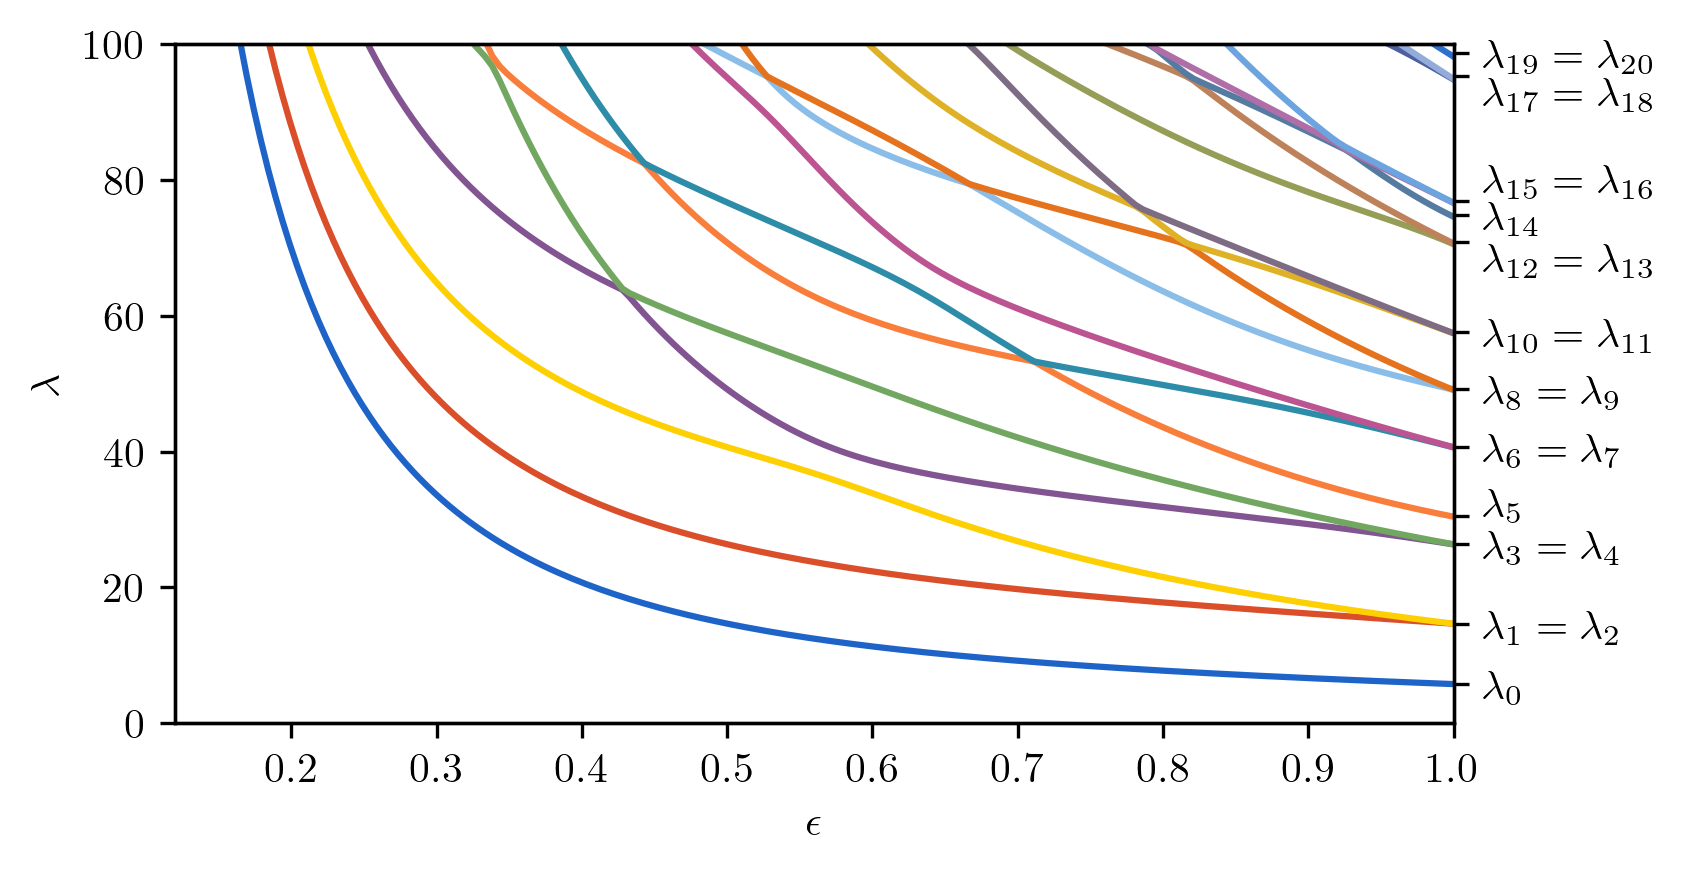

In [36]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5.5,3), dpi=300)
for kleur, (i, v) in zip(ugent.palet, enumerate(list(zip(*solutions)))):
    plt.plot(epsilons, v, color=kleur)
plt.ylim(0,100)
plt.xlim(0.12, 1)

ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())

ticks = []
labels = []

k = 0
for e, m in exact:
    ticks.append(e)
    labels.append(f"$\\lambda_{{{k}}}$"  if m == 1 else f"$\\lambda_{{{k}}} = \\lambda_{{{k+1}}}$")
    k += m
    
ax2.set_yticks(ticks)
ax2.set_yticklabels(labels)
ax2.get_yticklabels()[3].set_verticalalignment("baseline")
ax2.get_yticklabels()[7].set_verticalalignment("top")
ax2.get_yticklabels()[9].set_verticalalignment("bottom")
ax2.get_yticklabels()[10].set_verticalalignment("top")

ax1.set_xlabel("$\\epsilon$")
ax1.set_ylabel("$\\lambda$")
# plt.savefig("eigenvalues_flow.pdf", bbox_inches="tight")

None

In [37]:
exact

[(5.783185962946785, 1),
 (14.681970642123895, 2),
 (26.374616427163392, 2),
 (30.471262343662087, 1),
 (40.70646581820033, 2),
 (49.2184563216946, 2),
 (57.58294090329111, 2),
 (70.84999891909585, 2),
 (74.88700679069518, 1),
 (76.9389283336474, 2),
 (95.27757254403716, 2),
 (98.72627247724938, 2)]

In [47]:
def eigenfunction(E, eps=1, k=1):
    ts = np.linspace(-1, float(2*eps-1), nt+1)

    M = matrix_problem(eps)
    E, v = scsl.eigs(M, k=k, sigma=float(E))
    return [(E[i], np.real(v[:,i])) for i in range(len(E))]

In [78]:
%%time

import scipy.sparse.linalg as scsl
import scipy.optimize as sco

E = 45
tofind = sum(1 for e in solutions[-1] if e < E)
print(tofind)

def find_domain(i):
    j = 0
    while j < len(solutions) and solutions[j][i] > E:
        j += 1
        
    low = epsilons[j-1]
    high = epsilons[j] if j < len(solutions) else 1
    
    def f(eps):
        M = matrix_problem(eps)
        return E - np.real(scsl.eigs(M, k=1, sigma=float(E), return_eigenvectors=False)[0])
        
    return sco.root_scalar(f, x0=low, x1=high).root

raw_domains = pqdm(range(tofind), find_domain, n_jobs=10)
print(raw_domains)

domains = [[raw_domains[0], 1]]
i = 1
while i < len(raw_domains):
    eps = raw_domains[i]
    if abs(domains[-1][0] - eps) < 1e-6:
        domains[-1][1] += 1
    else:
        domains.append([eps, 1])
    i += 1
domains = list(map(tuple, domains))
print(domains)

8


QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

[0.2544806858241038, 0.3143543188484056, 0.44004337085454676, 0.5292301128294001, 0.6590316260020073, 0.785111118466624, 0.9149401533999686, 0.927952766031142]
[(0.2544806858241038, 1), (0.3143543188484056, 1), (0.44004337085454676, 1), (0.5292301128294001, 1), (0.6590316260020073, 1), (0.785111118466624, 1), (0.9149401533999686, 1), (0.927952766031142, 1)]
CPU times: user 100 ms, sys: 149 ms, total: 249 ms
Wall time: 13.9 s


In [79]:
eigenfunctions = []
for eps, m in domains:
    for Ecorrected, eigvec in eigenfunction(E, eps, k=m):
        print(Ecorrected, eps, m)
        ts = np.linspace(-1, float(2*eps-1), nt+1)

        Z = np.zeros((na+1, nt+1))
        Z[1:-1,1:-1] = eigvec.reshape((na-1, nt-1))

        X, Y = T(np.tile(alphas, (len(ts), 1)), np.tile(ts, (len(alphas), 1)).T)
        eigenfunctions.append((Ecorrected, eps, (X, Y, Z)))

(44.999999862379134+0j) 0.2544806858241038 1
(44.99999999955147+0j) 0.3143543188484056 1
(45.00000019145751+0j) 0.44004337085454676 1
(44.9999999664274+0j) 0.5292301128294001 1
(44.99999999827497+0j) 0.6590316260020073 1
(45.00000078441715+0j) 0.785111118466624 1
(45.000000000912195+0j) 0.9149401533999686 1
(44.999999865955076+0j) 0.927952766031142 1


0 0.2544806858241038
1 0.3143543188484056
2 0.44004337085454676
3 0.5292301128294001
4 0.6590316260020073
5 0.785111118466624
6 0.9149401533999686
7 0.927952766031142


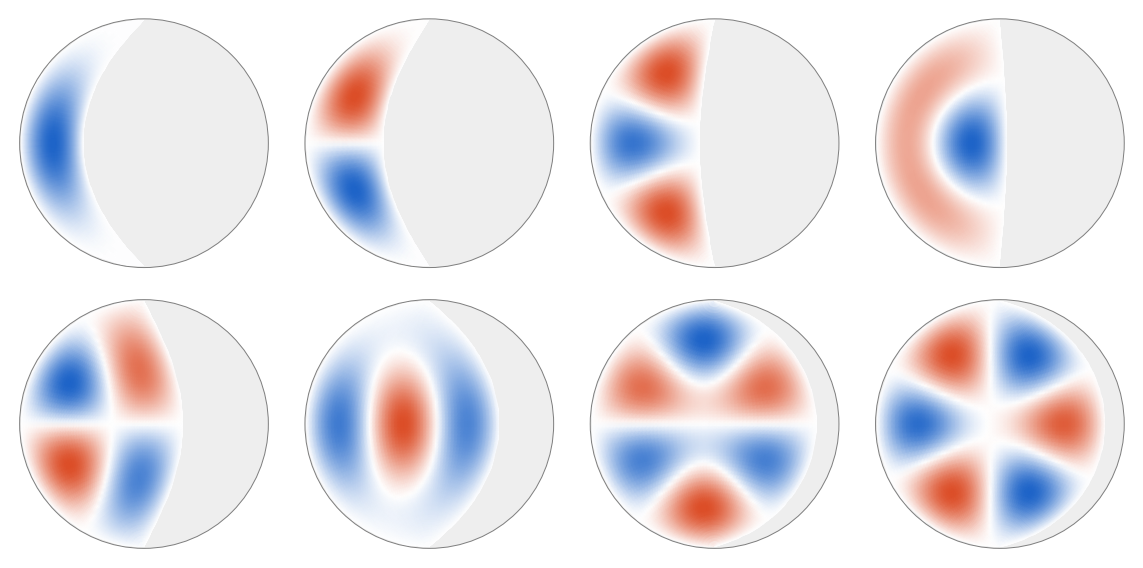

In [81]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

cols = 4
fig, axs = plt.subplots(2, cols, figsize=(4*cols, 8))

for row in axs:
    for ax in row:
        ax.axis('off')
        ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
        ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    
for plot_i, (E, eps, (X, Y, Z)) in enumerate(eigenfunctions):
    print(plot_i, eps)
    ts = np.linspace(-1, float(2*eps-1), nt+1)
    
    m = np.max(np.abs(Z))
    ax = axs[plot_i // cols, plot_i % cols]
    ax.set_aspect(1)
    moon = patches.Polygon([
        tuple(map(float, T(alpha, t))) for alpha, t in (
        [(-pi/2,1)]
        + [(alpha, ts[0]) for alpha in alphas]
        + [(pi/2,1)]
        + [(alpha, ts[-1]) for alpha in alphas[::-1]]
        + [(-pi/2,1)])
    ], facecolor="none")
    ax.add_patch(patches.Circle((0,0), 1.01, facecolor="#eeeeee", edgecolor="gray", linewidth=1, zorder=0))
    ax.add_patch(moon)
    ax.pcolormesh(X, Y, Z, shading='gouraud', vmin=-m, vmax=m, cmap=ugent.RdBu, clip_on=True, clip_path=moon, zorder=5)

plt.tight_layout()
plt.savefig("solutions.pdf", bbox_inches="tight")

In [ ]:
    np.tile(alphas, (len(ts), 1)).shape

(10, 52)

In [62]:
matrix_problem(0.6)

matrix([[ 8.43382497e+05, -5.67101927e+02,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.84790410e+02,  2.25259980e+05, -4.73755839e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.17423415e+02,  1.06976909e+05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.07227196e+05, -4.14085804e+02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.68215097e+02,  2.25430364e+05, -3.41573015e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -6.22540740e+02,  8.43475967e+05]])

In [60]:
len(ts)

62

In [61]:
nt

61